## Introduction

This is an open-source implementation of the paper **Hiding Images in Plain Sight: Deep Steganography, by Shumeet Baluja (Google), at NIPS 2017**. The paper is available [here](https://papers.nips.cc/paper/6802-hiding-images-in-plain-sight-deep-steganography).

This code was initially produced with the goal of reproducing to a reasonable degree the results achieved and described in the paper, for the **[Global NIPS Paper Implementation Challenge](https://nurture.ai/nips-challenge/)**.

**Abstract**: Steganography is the practice of concealing a secret message within another, ordinary, message. Commonly, steganography is used to unobtrusively hide a small message within the noisy regions of a larger image. In this study, we attempt to place a full size color image within another image of the same size. Deep neural networks are simultaneously trained to create the hiding and revealing processes and are designed to specifically work as a pair. The system is trained on images drawn randomly from the ImageNet database, and works well on natural images from a wide variety of sources. Beyond demonstrating the successful application of deep learning to hiding images, we carefully examine how the result is achieved and explore extensions. Unlike many popular steganographic methods that encode the secret message within the least significant bits of the carrier image, our approach compresses and distributes the secret image's representation across all of the available bits.

In [35]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import cv2
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [33]:
!pip install opencv-python

    100% |████████████████████████████████| 52.1MB 817kB/s eta 0:00:01  7% |██▌                             | 4.0MB 27.3MB/s eta 0:00:02
You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Config

In [9]:
### Constants ###
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

## Dataset creation
The Dataset we used is Tiny ImageNet Visual Recognition Challenge. It can be downloaded [here](https://tiny-imagenet.herokuapp.com/).

Our training set is made of a random subset of images from all 200 classes.

In [41]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        if c == '.DS_Store':
            continue
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs:
        if img_name_i == '.DS_Store':
            continue
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [42]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [43]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
org_input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [28]:
# Implement DCT to reduce the information on secret images

from scipy.fftpack import dct, idct
input_S = dct(org_input_S, norm='ortho')

print("Shape of secret =", input_S.shape)


Shape of secret = (1000, 64, 64, 3)


In [45]:
# For test files processing
tmpS = X_test[0:X_test.shape[0]//2]
test_C = X_test[X_test.shape[0]//2:]
test_S = dct(tmpS,norm='ortho')
print(test_C.shape, test_S.shape)


(12, 64, 64, 3) (12, 64, 64, 3)


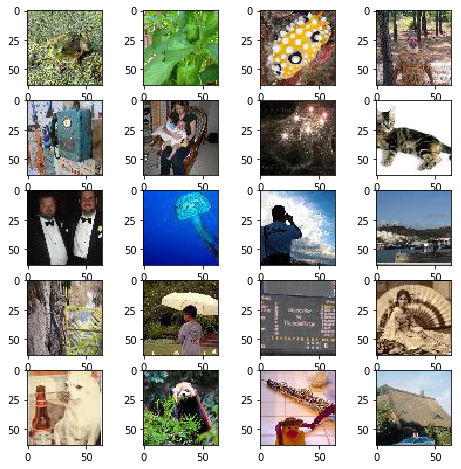

In [31]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()


## Model

The model is composed of three parts: The **Preparation Network**, **Hiding Network** (Encoder) and the **Reveal Network**. Its goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.

The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'. For stability, we add noise before the Reveal Network, as suggested by the paper. Although the author of the paper didn't originally specify the architecture of the three networks, we discovered aggregated layers showed good results. For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.

Note that the loss function for the Reveal Network is different from the loss function for the Preparation and Hiding Networks. In order to correctly implement the updates for the weights in the networks, we create stacked Keras models, one for the Preparation and Hiding Network (which share the same loss function) and one for the Reveal Network. To make sure weights are updated only once, we freeze the weights on the layers of the Reveal Network before adding it to the full model.

![](_images/network.png)

In [14]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [15]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

Instructions for updating:
Colocations handled automatically by placer.


## Training

Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32. 

In [16]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [17]:
import time

NB_EPOCHS = 1000
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    
    starting_time = time.process_time()
    
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))
    print("Data fitting takes", time.process_time() - starting_time, "seconds")


  0%|          | 0/32 [00:00<?, ?it/s]/Users/jihopark/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Epoch 1 | Batch: 992 of 1000. Loss AE  143342.23 | Loss Rev   78764.67: 100%|██████████| 32/32 [12:13<00:00, 17.34s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4144.754978000001 seconds


Epoch 2 | Batch: 992 of 1000. Loss AE   32768.16 | Loss Rev   18460.30: 100%|██████████| 32/32 [11:39<00:00, 18.15s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4202.04169 seconds


Epoch 3 | Batch: 992 of 1000. Loss AE   20434.82 | Loss Rev   11255.34: 100%|██████████| 32/32 [12:53<00:00, 21.27s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4443.712405999999 seconds


Epoch 4 | Batch: 992 of 1000. Loss AE   20547.86 | Loss Rev   13181.11: 100%|██████████| 32/32 [14:56<00:00, 20.82s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4761.65235 seconds


Epoch 5 | Batch: 992 of 1000. Loss AE   15457.56 | Loss Rev    8679.67: 100%|██████████| 32/32 [13:27<00:00, 19.41s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4736.356088 seconds


Epoch 6 | Batch: 992 of 1000. Loss AE   13278.21 | Loss Rev    9007.32: 100%|██████████| 32/32 [12:53<00:00, 17.43s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4512.716818000001 seconds


Epoch 7 | Batch: 992 of 1000. Loss AE   13221.65 | Loss Rev    8870.10: 100%|██████████| 32/32 [12:08<00:00, 17.25s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4383.844804 seconds


Epoch 8 | Batch: 992 of 1000. Loss AE   12741.50 | Loss Rev    9284.27: 100%|██████████| 32/32 [11:49<00:00, 17.51s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4333.201046000002 seconds


Epoch 9 | Batch: 992 of 1000. Loss AE   15396.41 | Loss Rev    9702.39: 100%|██████████| 32/32 [12:01<00:00, 18.30s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4296.894520000002 seconds


Epoch 10 | Batch: 992 of 1000. Loss AE    9943.17 | Loss Rev    6974.97: 100%|██████████| 32/32 [11:35<00:00, 17.13s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4267.818432 seconds


Epoch 11 | Batch: 992 of 1000. Loss AE    9584.02 | Loss Rev    7122.87: 100%|██████████| 32/32 [11:31<00:00, 16.58s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4241.222274 seconds


Epoch 12 | Batch: 992 of 1000. Loss AE   22656.54 | Loss Rev   14963.31: 100%|██████████| 32/32 [12:40<00:00, 18.97s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4360.179295999995 seconds


Epoch 13 | Batch: 992 of 1000. Loss AE   11007.36 | Loss Rev    7094.62: 100%|██████████| 32/32 [13:03<00:00, 18.63s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4742.092252000002 seconds


Epoch 14 | Batch: 992 of 1000. Loss AE    9650.03 | Loss Rev    7024.82: 100%|██████████| 32/32 [12:45<00:00, 18.57s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4835.075539999998 seconds


Epoch 15 | Batch: 992 of 1000. Loss AE   14211.32 | Loss Rev    9784.65: 100%|██████████| 32/32 [12:32<00:00, 18.39s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4792.752652000003 seconds


Epoch 16 | Batch: 992 of 1000. Loss AE    9161.64 | Loss Rev    6476.24: 100%|██████████| 32/32 [12:37<00:00, 18.58s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4767.701432000002 seconds


Epoch 17 | Batch: 992 of 1000. Loss AE    8441.76 | Loss Rev    6354.14: 100%|██████████| 32/32 [17:07<00:00, 23.53s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4974.018714000005 seconds


Epoch 18 | Batch: 992 of 1000. Loss AE    8243.51 | Loss Rev    6400.41: 100%|██████████| 32/32 [15:27<00:00, 19.50s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4771.383818000002 seconds


Epoch 19 | Batch: 992 of 1000. Loss AE   26932.08 | Loss Rev   16436.24: 100%|██████████| 32/32 [13:26<00:00, 21.79s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4603.564016000004 seconds


Epoch 20 | Batch: 992 of 1000. Loss AE   12412.85 | Loss Rev    7035.85: 100%|██████████| 32/32 [15:47<00:00, 24.16s/it]


Data fitting takes 4938.11759400001 seconds


Epoch 21 | Batch: 992 of 1000. Loss AE    9810.36 | Loss Rev    6785.16: 100%|██████████| 32/32 [15:58<00:00, 24.45s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 5347.180269999997 seconds


Epoch 22 | Batch: 992 of 1000. Loss AE    9532.92 | Loss Rev    6764.76: 100%|██████████| 32/32 [15:09<00:00, 20.41s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 5292.550805999999 seconds


Epoch 23 | Batch: 992 of 1000. Loss AE    8491.05 | Loss Rev    6274.18: 100%|██████████| 32/32 [13:24<00:00, 19.40s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4973.735190000007 seconds


Epoch 24 | Batch: 992 of 1000. Loss AE   17886.56 | Loss Rev   12548.17: 100%|██████████| 32/32 [13:07<00:00, 19.31s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4868.052065999989 seconds


Epoch 25 | Batch: 992 of 1000. Loss AE    9150.34 | Loss Rev    6266.38: 100%|██████████| 32/32 [13:07<00:00, 19.32s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4880.0925080000015 seconds


Epoch 26 | Batch: 992 of 1000. Loss AE    8011.98 | Loss Rev    5981.68: 100%|██████████| 32/32 [13:12<00:00, 19.46s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4901.618886000011 seconds


Epoch 27 | Batch: 992 of 1000. Loss AE    8022.38 | Loss Rev    6180.73: 100%|██████████| 32/32 [13:22<00:00, 19.49s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4919.816447999998 seconds


Epoch 28 | Batch: 992 of 1000. Loss AE    7379.36 | Loss Rev    5718.06: 100%|██████████| 32/32 [13:17<00:00, 19.58s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4939.591575999992 seconds


Epoch 29 | Batch: 992 of 1000. Loss AE    8018.46 | Loss Rev    6334.16: 100%|██████████| 32/32 [13:25<00:00, 19.71s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

Data fitting takes 4959.77378399999 seconds


Epoch 30 | Batch:   0 of 1000. Loss AE    8417.79 | Loss Rev    6849.42:   3%|▎         | 1/32 [00:27<14:04, 27.25s/it]

KeyboardInterrupt: 

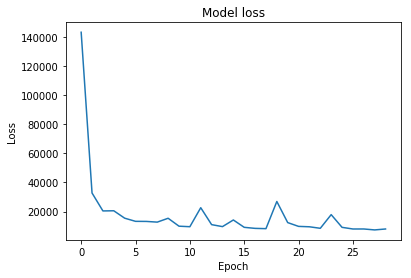

In [18]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [20]:
# Save model
autoencoder_model.save_weights('./final.hdf5')

In [ ]:
# Load model
# autoencoder_model.load_weights('models/final.hdf5')

## Results

In [72]:
# Retrieve decoded predictions.
result = autoencoder_model.predict([test_S, test_C])
encoded_image = encoder_model.predict([test_S,test_C])
decoded_S, decoded_C = result[...,0:3], result[...,3:6]
decoded_S = idct(decoded_S, norm='ortho')
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - test_S), np.abs(decoded_C - test_C) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

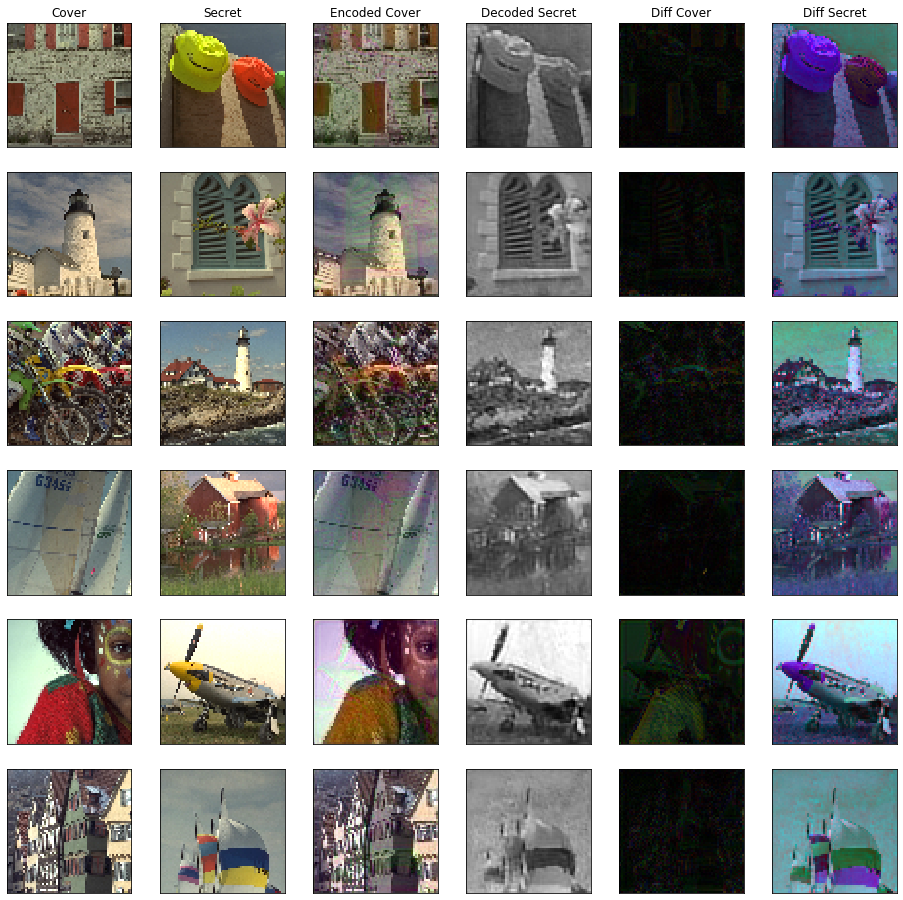

In [73]:
# Configs for results display
# Show images in gray scale
SHOW_GRAY = False

# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)


# display test Result
plt.figure(1,figsize=(16,16))
for i, idx in zip(range(6),range(6)):
    n_col = 6 if SHOW_DIFF else 4
    show_image(test_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    #input_S
    show_image(tmpS[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    show_image(encoded_image[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')


In [57]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75)
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75)
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [58]:
# Print pixel-wise average errors in a 256 scale.
# S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)
S_error, C_error = pixel_errors(test_S, test_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 110.76211
C error per pixel [0, 255]: 15.748688


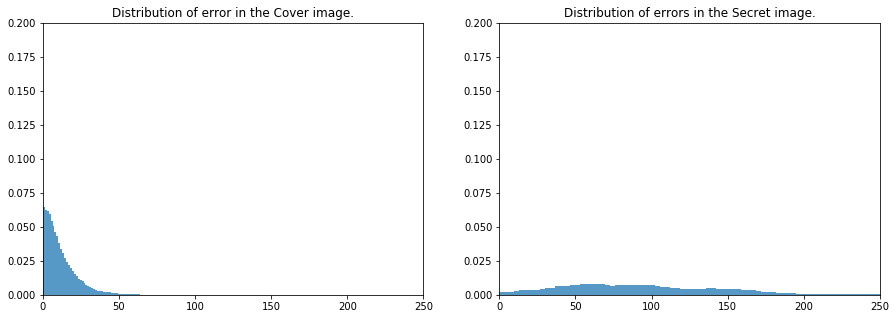

In [59]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


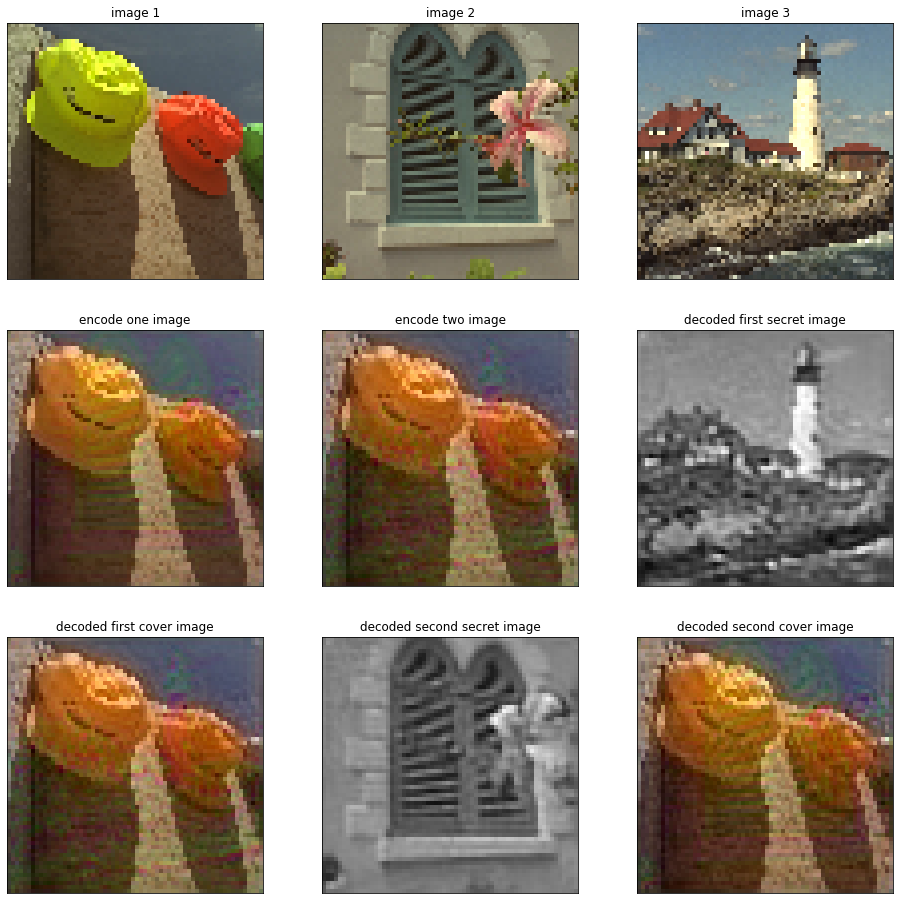

In [102]:
plt.figure(1,figsize=(16,16))
# cover
img1 = tmpS[0]

ax = plt.subplot(3,3,1)
plt.imshow(img1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("image 1")

img1 = img1.reshape(1,64,64,3)

# secret 1
img2 = tmpS[1]

ax = plt.subplot(3,3,2)
plt.imshow(img2)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("image 2")

img2 = dct(img2,norm='ortho')
img2 = img2.reshape(1,64,64,3)

# secret 2
img3 = tmpS[2]

ax = plt.subplot(3,3,3)
plt.imshow(img3)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("image 3")

img3 = dct(img3,norm='ortho')
img3 = img3.reshape(1,64,64,3)

# first encoding
result1 = encoder_model.predict([img2, img1])
# second encoding
result2 = encoder_model.predict([img3,result1])
# second encoding then first decoding
final = autoencoder_model.predict([img3,result1])
decoded_ss, decoded_cc = final[...,0:3], final[...,3:6]
decoded_ss = idct(decoded_ss, norm='ortho')
# second decoding
second_decoded = autoencoder_model.predict([img2,decoded_cc])
decoded_sss, decoded_ccc = second_decoded[...,0:3], second_decoded[...,3:6]
decoded_sss = idct(decoded_sss, norm='ortho')

# display test Result
result1 = result1.reshape(64,64,3)
result2 = result2.reshape(64,64,3)
decoded_ss = decoded_ss.reshape(64,64,3)
decoded_cc = decoded_cc.reshape(64,64,3)
decoded_sss = decoded_sss.reshape(64,64,3)
decoded_ccc = decoded_ccc.reshape(64,64,3)

ax = plt.subplot(3,3,4)
plt.imshow(result1, cmap = plt.get_cmap('gray'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("encode one image")

ax = plt.subplot(3,3,5)
plt.imshow(result2, cmap = plt.get_cmap('gray'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("encode two image")

ax = plt.subplot(3,3,6)
plt.imshow(decoded_ss, cmap = plt.get_cmap('gray'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("decoded first secret image")

ax = plt.subplot(3,3,7)
plt.imshow(decoded_cc, cmap = plt.get_cmap('gray'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("decoded first cover image")

ax = plt.subplot(3,3,8)
plt.imshow(decoded_sss, cmap = plt.get_cmap('gray'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("decoded second secret image")

ax = plt.subplot(3,3,9)
plt.imshow(decoded_ccc, cmap = plt.get_cmap('gray'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("decoded second cover image")

plt.show()